<h1 style="text-align: center;">Reconhecimento de Padrões - T3</h1>
<h2 style="text-align: center;">Erick Lima Trentini</h2>

# 1. Introdução

Neste trabalho iremos utilizar algumas métricas de qualidade de clusters, onde o algoritmo k-means será utilizado em um dataset sem labels, e as métricas serão utilizadas para escolhermos o K que melhor representa a separação dos dados. Além disso, os clusters criados pelo melhor K serão analizados.

In [60]:
from sklearn.cluster import MiniBatchKMeans
import datasets
import utils
import tester
import models
import numpy as np
import matplotlib.pyplot as plt
import progressbar
%matplotlib inline

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 2. Dataset

O dataset deste trabalho possui 1701 linhas de dados e 6 atributos.

Por esse motivo, não é um dataset tão grande e permite rodar os algoritmos de forma rápida, com exceção do índice de DUNN, que por fazer muitas comparações acaba sendo custoso.

In [13]:
data = np.loadtxt('data/datasetTC3.dat')
print(data.shape)
print()
print(data)

(1701, 6)

[[100.000 2.000 477.750 3.464 3.464 10.000]
 [50.000 4.250 975.497 1.477 1.597 10001.000]
 [100.000 3.214 3747.114 1.023 0.985 15577.000]
 ...
 [100.000 2.000 466.714 2.335 2.663 9928003.000]
 [100.000 2.000 130.290 3.464 3.464 9950030.000]
 [100.000 2.000 114.828 3.464 3.464 9995020.000]]


## 2.1. Visualização dos dados

Para a visualização dos dados, como de costume, será utilizado o PCA para a projeção dos dados.

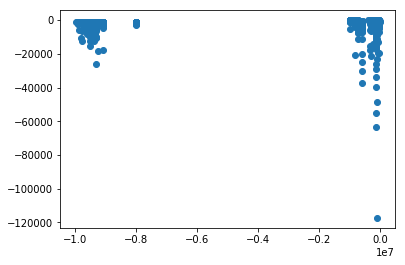

In [22]:
pca = utils.PCA()
pca.fit(data)
pca_data = pca.transform(data, min_var=1)
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.show()

Podemos perceber apenas olhando para a separação dos dados que eles se apresentam em 2 ou 3 clusters, sendo 1 mais separado dos outros. Como estamos olhando apenas para uma projeção dos dados, é possível que não estejamos vendo outras separações no espaço. Para isso, utilizaremos os índices de qualidade dos clusters e veremos o resultado da separação mais a frente.

# 3. Índices de Qualidade dos Clusters

Para melhorar a velocidade das aplicações dos índices, foi construída uma matriz esparsa que calcula as distâncias entre os elementos sob demanda.

In [29]:
class SparseDistanceMatrix:
    def __init__(self, X):
        self.X = X
        self.matrix = {}
        
    def get(self, i, j):
        if i == j:
            return 0.
        if i > j:
            i, j = j, i
        if (i, j) not in self.matrix:
            self.matrix[(i, j)] = utils.distance(self.X[i], self.X[j])
        return self.matrix[(i, j)]
    
SDM = SparseDistanceMatrix(data)

## 3.1. Índice de Dunn

Este índice é o mais demorado de todos, já que é necessário o cálculo de distância entre todas as combinações de elementos dentro de um cluster, elementos entre 2 clusters em cada combinação de 2 clusters.

In [40]:
def inter_cluster_distance(SDM, c1, c2):
    return min(SDM.get(x1, x2) for x1 in c1 for x2 in c2)

def cluster_diameter(SDM, c):
    return max(SDM.get(c[i], c[j]) for i in range(len(c)) for j in range(i+1, len(c)))

def dunn_index(SDM, model, X):
    clusters = [[] for _ in range(model.n_clusters)]
    for i in range(len(X)):
        clusters[model.labels_[i]].append(i)
        
    num = min(inter_cluster_distance(SDM, clusters[i], clusters[j]) for i in range(model.n_clusters) for j in range(i+1, model.n_clusters))
    den = max(cluster_diameter(SDM, c) for c in clusters)
    return num / den

## 3.2. Índice DB (Davies - Bouldin)

In [24]:
def d(model, i, j):
    return utils.distance(model.cluster_centers_[i], model.cluster_centers_[j])

def S(model, X, i):
    m = model.cluster_centers_[i]
    q = 2
    cluster = [x for k, x in enumerate(X) if model.labels_[k] == i]
    return (sum(utils.distance(x, m)**q for x in cluster) / len(cluster))**(1/q)

def R(model, X, i):
    return max((S(model, X, i) + S(model, X, j)) / d(model, i, j) for j in range(model.n_clusters) if j != i)

def db_index(model, X):
    return sum(R(model, X, i) for i in range(model.n_clusters)) / model.n_clusters

## 3.3. Índice CH (Calinski - Harabasz)

In [25]:
def Bk(clusters, X):
    x_mean = np.mean(X, axis=0)
    norm_prototypes = np.array([np.mean(c, axis=0) - x_mean for c in clusters])
    return np.sum([len(c) * np.outer(w, w) for c, w in zip(clusters, norm_prototypes)], axis=0)

def Wk(clusters, X):
    Ws = np.array([np.mean(c, axis=0) for c in clusters])
    return np.sum([np.sum([np.outer(x - w, x - w) for x in c], axis=0) for c, w in zip(clusters, Ws)], axis=0)

def ch_index(model, X):
    clusters = [[] for _ in range(model.n_clusters)]
    for i, x in enumerate(X):
        clusters[model.labels_[i]].append(x)
    return (Bk(clusters, X).trace() / (model.n_clusters - 1)) / (Wk(clusters, X).trace() / (len(X) - model.n_clusters))
        

## 3.4. Silhouette

In [53]:
def A(SDM, i, his_cluster):
    return np.mean([SDM.get(i, j) for j in his_cluster if j != i])
    
def B(SDM, i, his_cluster_number, all_clusters):
    return min([np.mean([SDM.get(i, j) for j in all_clusters[k]]) for k in range(len(all_clusters)) if k != his_cluster_number])

def Silhouette_S(SDM, i, his_cluster_number, all_clusters):
    a_i = A(SDM, i, all_clusters[his_cluster_number])
    b_i = B(SDM, i, his_cluster_number, all_clusters)
    return (b_i - a_i) / max(a_i, b_i)

def silhouette(SDM, model, X):
    clusters = [[] for _ in range(model.n_clusters)]
    for i in range(len(X)):
        clusters[model.labels_[i]].append(i)
        
    all_s = [Silhouette_S(SDM, i, cluster_n, clusters) for cluster_n in range(len(clusters)) for i in clusters[cluster_n]]
    
    return np.mean(all_s)

# 4. Descobrindo o Melhor K

Para isso, testamos com valores de K variando entre 2 e 11. Todos os índices são calculados para cada K e no final seus valores serão plotados.

In [54]:
dunn_indexes = []
db_indexes = []
ch_indexes = []
silhouettes = []

models = [MiniBatchKMeans(n_clusters=k) for k in range(2, 11)]
for m in models:
    m.fit(data)

with progressbar.ProgressBar(max_value=9) as bar:
    for i, m in enumerate(models):
        bar.update(i)
        dunn_indexes.append(dunn_index(SDM, m, data))
        db_indexes.append(db_index(m, data))
        ch_indexes.append(ch_index(m, data))
        silhouettes.append(silhouette(SDM, m, data))
        

100% (9 of 9) |##########################| Elapsed Time: 0:00:57 Time:  0:00:57


## 4.1. Dunn (Maior é melhor)

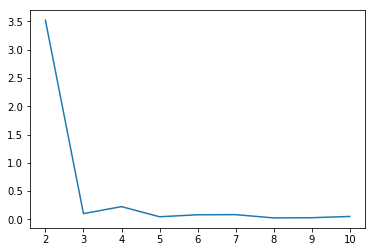

In [55]:
plt.plot(range(2, 11), dunn_indexes)
plt.show()

## 4.2. DB (Menor é melhor)

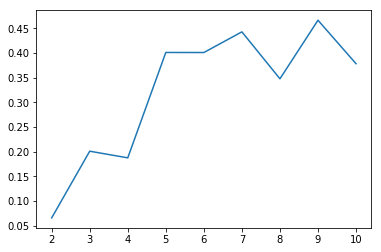

In [56]:
plt.plot(range(2, 11), db_indexes)
plt.show()

## 4.3. CH (Menor é melhor)

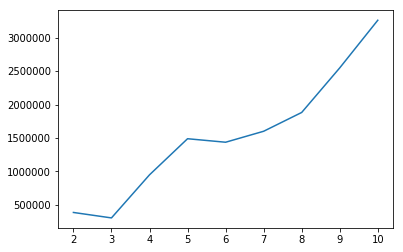

In [57]:
plt.plot(range(2, 11), ch_indexes)
plt.show()

## 4.4. Silhouette (Maior é melhor)

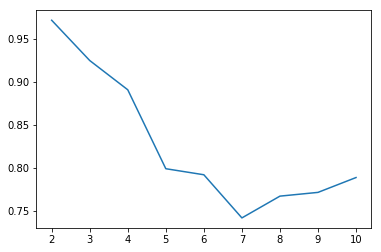

In [58]:
plt.plot(range(2, 11), silhouettes)
plt.show()

Como podemos perceber, a quantidade de 2 clusters se mostra ideal em todos os casos. 

Com exceção do índice de Dunn, a quantidade de 3 clusters também não é uma má escolha. Isso se dá pois o índice de Dunn é muito sensível a clusters que tenham os elementos muito próximos uns dos outros, bem como se o cluster possuir outliers, já que é baseado em máximos e mínimos.

Logo, K=2 parece uma escolha razoável para o número de clusters deste dataset.

Logo, aqui está um plot dos dados clusterizados que nos mostra exatamente o que havíamos analizado na introdução.

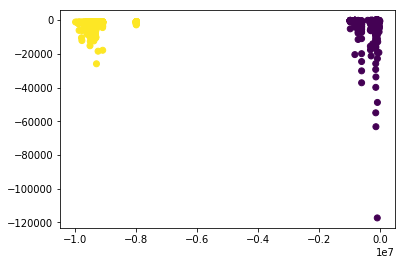

In [59]:
pca = utils.PCA()
pca.fit(data)
pca_data = pca.transform(data, min_var=1)

m = models[0]

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=m.labels_)
plt.show()

# 5. Análise dos Clusters

In [63]:
clustered_data = {i : [] for i in range(m.n_clusters)}
for i, x in enumerate(data):
    clustered_data[m.labels_[i]].append(x)

clustered_dataframes = [pd.DataFrame(clustered_data[i]) for i in clustered_data]

In [97]:
from IPython.display import display, HTML
import pandas as pd
pd.set_option('display.precision',4)
pd.set_option('display.float_format', lambda x: '{.3f}'.format(x))

cols = ['count', 'mean', 'std', 'min', 'Max', '50%']

th_props = [('font-size', '14px'),('text-align', 'center'),
            ('font-weight', 'bold'),('color', '#6d6d6d'),('background-color', '#CCC')]

# Set CSS properties for td elements in dataframe
td_props = [('font-size', '14px'),('text-align', 'center')]

# Set table styles
styles = [dict(selector="th", props=th_props), dict(selector="td", props=td_props)]

for k, df in enumerate(clustered_dataframes):
    style = df.describe().drop('count').transpose().style.set_table_styles(styles)
    print('Cluster {}:'.format(k))
    print('Quantidade de dados: {}'.format(len(df)))
    display(style)
    


Cluster 0:
Quantidade de dados: 811


,mean,std,min,25%,50%,75%,max
0,98.62,7.918,0,100,100,100,100
1,4.326,4.496,0,2,3.167,4.764,72.67
2,1913,6594,38.22,109.3,342.2,1101,1.173e+05
3,2.087,1.05,0.2081,1.175,1.809,3.464,3.464
4,2.163,1.014,0.2711,1.287,2,3.464,3.464
5,2.516e+05,2.753e+05,10,8.357e+04,1.351e+05,2.545e+05,9.762e+05


Cluster 1:
Quantidade de dados: 890


,mean,std,min,25%,50%,75%,max
0,99.62,3.02,50,100,100,100,100
1,4.092,2.686,0,2.5,3.75,5,37
2,1009,1948,45.34,149.9,366,1005,2.497e+04
3,2.241,1.034,0.3837,1.287,2.335,3.464,3.464
4,2.285,1.01,0.4253,1.359,2.335,3.464,3.464
5,9.354e+06,3.229e+05,8e+06,9.333e+06,9.372e+06,9.504e+06,9.995e+06


# 6. Conclusão

Com os índices de qualidade de cluster, podemos ter uma métrica objetiva para decidir a quantidade de clusters, ao invés de uma análise subjetiva que, devido à nossa impossibilidade de enxergar mais que 3 dimensões, pode impedir a visualização de separações nos dados.

Alguns desses índices são muito demorados por necessitarem calcular distâncias entre várias combinações 2 a 2 dos dados, mas ao criar uma matriz de distância para guardar as distâncias já calculadas, o processo de testar as métricas para vários Ks se torna extremamente mais rápido.

Link do github: https://github.com/ericklt/pattern-recognition